<a href="https://colab.research.google.com/github/rashidmeras/EVA-M6/blob/master/EVA_S5_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVA (M6) Session5 Assignment: 

Objective:

> Using the network defined in Assignment 4 change the code to include:

> * Image Normalization,
> * L2 - Regularization,
> * ReLU after BN,
> * Run new code for 40 epochs and save the model with highest validation accuracy,
> * Find out 25 mis-classified images from the validation dataset and create an image gallery.


*So lets Start!!*

Basic Setup:
* Install the Keras API library
* From Keras API library import APIs needed to create a DNN

In [0]:
!pip install -q keras
import keras
import tensorflow as tf

import numpy as np

from keras.models import Sequential
from keras.layers import Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from keras.datasets import mnist

Let's fix a random seed=**990** for reproducibility!

In [0]:
# fix random seed for reproducibility
seed = 990
np.random.seed(seed)


Load the the data, shuffled and split between train and test sets.

The MNIST dataset consists of pair, “handwritten digit image” and “label”. Digit ranges from 0 to 9, meaning 10 patterns in total.

* handwritten digit image (X_train): This is gray scale image with size 28 x 28 pixel.
* label (y_train): This is actual digit number this handwritten digit image represents. It is the numbers between including 0 to 9.

Matplotlib is a Python 2D plotting library & PyPlot is a shell-like interface to Matplotlib.
Use Matplotlib to plot first few images.

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


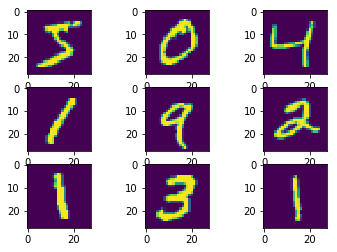

In [87]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

from matplotlib import pyplot

# summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(X_train[i])
# show the figure
pyplot.show()

Flatten 28x28 images to a 28*28=784 vector for each image.

> The images in the dataset are of 28*28 dimensions which is difficult to accommodate in a simple multilayer neural network. Therefore we need to convert the images into a single dimension where each image contains 784-pixel data using the reshape() function. Then do pixel normalization by dviding each pixel by 255.

In [0]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Convert class vectors to binary class matrices:

> We need to perform one-hot encoding of the class labels for getting a vector of class integers into a binary matrix. We need to do this to do a “binarization” of the category and so that we can include it as a feature to train the neural network.

We can use the built in np_utils.to_categorical() helper function in keras to do this.

In [0]:
# Convert 1-dimensional class arrays to 10-dimensional class matrices
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

## Image Normalization

In [90]:
# confirm scale of pixels
print('Train min=%.3f, max=%.3f' % (X_train.min(), X_train.max()))
print('Test min=%.3f, max=%.3f' % (X_test.min(), X_test.max()))

# create generator that centers pixel values
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

# calculate mean on training dataset
datagen.fit(X_train)

print('Data Generator mean=%.3f, std=%.3f' % (datagen.mean, datagen.std))

# prepare an iterators to scale images
train_iterator = datagen.flow(X_train, Y_train, batch_size=25)
test_iterator = datagen.flow(X_test, Y_test, batch_size=25)
print('Batches train=%d, test=%d' % (len(train_iterator), len(test_iterator)))

Train min=0.000, max=1.000
Test min=0.000, max=1.000
Data Generator mean=0.131, std=0.308
Batches train=2400, test=400


## New Network

 The new network is implement as shown below with the following features:
 > * ReLU after BN 
 > * Dropout after ReLU

In [115]:
from keras.layers import Activation
model = Sequential()

#Layer1: Cov->BN->Act->DO i/p:|28x28x1|Conv(3x3x1)x32| o/p:|26x26x32|
model.add(Convolution2D(32, 3, 3, use_bias=False, input_shape=(28,28,1), kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

#Layer2: Cov->BN->Act->DO i/p:|26x26x8|Conv(3x3x8)x16| o/p:|24x24x16|
model.add(Convolution2D(16, 3, 3, use_bias=False, kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

#Layer3: Cov->BN->Act->DO i/p:|24x24x4|Conv(3x3x4)x16| o/p:|22x22x16|
model.add(Convolution2D(16, 3, 3, use_bias=False, kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

#Layer4: Cov->BN->Act->DO i/p:|22x22x4|Conv(1x1x4)x12| o/p:|22x22x12|
model.add(Convolution2D(12, 1, 1, use_bias=False, kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

#Layer5: Max-Pooling layer
model.add(MaxPooling2D(pool_size=(2, 2))) #11

#Layer6: Cov->BN->Act->DO i/p:|11x11x3|Conv(3x3x3)x16| o/p:|9x9x16|
model.add(Convolution2D(16, 3, 3, use_bias=False, kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

#Layer7: Cov->BN->Act->DO i/p:|9x9x16|Conv(3x3x16)x16| o/p:|7x7x16|
model.add(Convolution2D(16, 3, 3, use_bias=False, kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

#Layer8: Cov->BN->Act->DO i/p:|7x7x16|Conv(7x7x16)x10| o/p:|1x1x10|
model.add(Convolution2D(10, 7, 7, use_bias=False, kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.1))

#Layer9: Flatten & activation
model.add(Flatten())
model.add(Activation('softmax'))

#Print model summary
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), use_bias=False, input_shape=(28, 28, 1..., kernel_regularizer=<keras.reg...)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), use_bias=False, kernel_regularizer=<keras.reg...)`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, (1, 1), use_bias=False, kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 26, 26, 32)        288       
_________________________________________________________________
batch_normalization_66 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
activation_65 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
dropout_66 (Dropout)         (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 24, 24, 16)        4608      
_________________________________________________________________
batch_normalization_67 (Batc (None, 24, 24, 16)        64        
_________________________________________________________________
activation_66 (Activation)   (None, 24, 24, 16)        0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (7, 7), use_bias=False, kernel_regularizer=<keras.reg...)`


Compile the model:
> * Save the model with highest validation accuracy

In [116]:
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

save_mcp = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history = model.fit_generator(train_iterator, steps_per_epoch=len(train_iterator), epochs=40, validation_data=(X_test, Y_test), callbacks=[save_mcp], verbose=1)

Epoch 1/40
2400/2400 [==============================] - 39s 16ms/step - loss: 0.8717 - acc: 0.8331 - val_loss: 1.0464 - val_acc: 0.8862

Epoch 00001: val_acc improved from -inf to 0.88620, saving model to best_model.h5
Epoch 2/40
2400/2400 [==============================] - 30s 13ms/step - loss: 0.4825 - acc: 0.8763 - val_loss: 1.3749 - val_acc: 0.5012

Epoch 00002: val_acc did not improve from 0.88620
Epoch 3/40
2400/2400 [==============================] - 30s 13ms/step - loss: 0.4345 - acc: 0.8862 - val_loss: 1.3139 - val_acc: 0.4958

Epoch 00003: val_acc did not improve from 0.88620
Epoch 4/40
2400/2400 [==============================] - 32s 13ms/step - loss: 0.4122 - acc: 0.8937 - val_loss: 0.7730 - val_acc: 0.8674

Epoch 00004: val_acc did not improve from 0.88620
Epoch 5/40
2400/2400 [==============================] - 31s 13ms/step - loss: 0.3916 - acc: 0.9004 - val_loss: 0.9058 - val_acc: 0.7647

Epoch 00005: val_acc did not improve from 0.88620
Epoch 6/40
2400/2400 [===========

Display the Train and Test Accuracy from the saved model

In [117]:
# load the saved model
saved_model = load_model('best_model.h5')

# evaluate model
train_acc = saved_model.evaluate_generator(train_iterator, steps=len(train_iterator), verbose=1)
test_acc  = saved_model.evaluate_generator(test_iterator, steps=len(test_iterator), verbose=1)
print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc[1]*100, test_acc[1]*100))

400/400 [==============================] - 2s 4ms/step
Train Accuracy: 97.873, Test Accuracy: 97.750


## Image gallery of 25 mis-classified images from the validation dataset

## Total false predictions:  2552 out of 10000


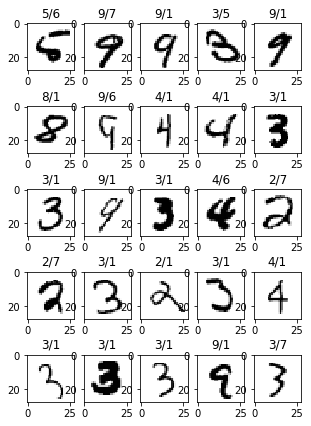

In [118]:
import matplotlib.cm as cm

# convert one-hot encodings into labels
def one_hot_to_dense(labels_one_hot):
    return np.argmax(labels_one_hot,1)

# test label  
y_pred = model.predict(X_test)
# print(y_pred[:10])
# print(y_test[:10])

y_valid_pred_label = one_hot_to_dense(y_pred)
y_valid_label = one_hot_to_dense(Y_test)
y_val_false_index = []

for i in range(y_valid_label.shape[0]):
    if y_valid_pred_label[i] != y_valid_label[i]:
        y_val_false_index.append(i)

print('## Total false predictions: ', len(y_val_false_index),'out of', len(Y_test))

plt.figure(figsize=(10,15))

for j in range(0,5):
    for i in range(0,5):
        if j*10+i<len(y_val_false_index):
            plt.subplot(10,10,j*10+i+1)
            plt.title('%d/%d'%(y_valid_label[y_val_false_index[j*10+i]],
                               y_valid_pred_label[y_val_false_index[j*10+i]]))
            plt.imshow(X_test[y_val_false_index[j*10+i]].reshape(28,28),cmap=cm.binary)   

###Summary:

> In this assignment we used image normalization techniques and developed a netwrok that had ReLU after Batch Normalization. The requirement of L2 regularization was to be done in the final loss function but this was not achevable in this assignment and hence  L2 regularization was done at each layer.

> ModelCheckpoint was used  to save model that had best validation accuracy. Also in the final section image gallery was implemented to display 25 mis-classified images from the validation dataset.


###Thank you!

Reference:

1. [Kaggle: MNIST Image Classification](https://www.kaggle.com/raoulma/mnist-image-class-tensorflow-cnn-99-51-test-acc)
2. [An Overview of Regularization Techniques in Deep Learning ](https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/)
3. [How to Normalize, Center, and Standardize Images With the ImageDataGenerator in Keras](https://machinelearningmastery.com/how-to-normalize-center-and-standardize-images-with-the-imagedatagenerator-in-keras/)
4. [Differences between L1 and L2 as Loss Function and Regularization](http://www.chioka.in/differences-between-l1-and-l2-as-loss-function-and-regularization/)
5. [L1 and L2 Regularization](https://medium.com/datadriveninvestor/l1-l2-regularization-7f1b4fe948f2)
